Let's start with importing some standard packages. We will also change some global properties of matplotlib (the plotting package we will use) to make the figures more readable.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
import math
from timeit import default_timer as timer

plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['font.size'] = 16

Then, let's download the CIFAR-10 dataset. PyTorch provides a handy way to do it by means of a `torchvision.datasets` utility class. It returns a `torch.utils.data.Dataset` object, which basically is a list of items and labels as we defined in the lecture. You can check the [documentation](https://pytorch.org/docs/stable/data.html#module-torch.utils.data) and or experiment with it as we do below to understand how to use it. 

In [2]:
num_classes = 10
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

train_ds = torchvision.datasets.CIFAR10(root="/data/", train=True, transform=transforms.ToTensor(), download=True)
test_ds = torchvision.datasets.CIFAR10(root="/data/", train=False, transform=transforms.ToTensor())

train_ds

Extracting /data/cifar-10-python.tar.gz to /data/


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: /data/
    Split: Train
    StandardTransform
Transform: ToTensor()

In [3]:
isinstance(train_ds, torch.utils.data.Dataset)

True

You can index into a dataset, normally with an integer index as you would do with a list. 

In [4]:
print(type(train_ds[0]))
len(train_ds[0])

<class 'tuple'>


2

2 elements... probably the image and the label. Let's check the second, which should be the label.

In [5]:
train_ds[0][1]

6

It's a 6! Well, let's use the list of classes we defined above to get something more meaningful 

In [6]:
classes[train_ds[0][1]]

'frog'

It's a frog! Let's look at the image, then.

In [7]:
train_ds[0][0]

tensor([[[0.2314, 0.1686, 0.1961,  ..., 0.6196, 0.5961, 0.5804],
         [0.0627, 0.0000, 0.0706,  ..., 0.4824, 0.4667, 0.4784],
         [0.0980, 0.0627, 0.1922,  ..., 0.4627, 0.4706, 0.4275],
         ...,
         [0.8157, 0.7882, 0.7765,  ..., 0.6275, 0.2196, 0.2078],
         [0.7059, 0.6784, 0.7294,  ..., 0.7216, 0.3804, 0.3255],
         [0.6941, 0.6588, 0.7020,  ..., 0.8471, 0.5922, 0.4824]],

        [[0.2431, 0.1804, 0.1882,  ..., 0.5176, 0.4902, 0.4863],
         [0.0784, 0.0000, 0.0314,  ..., 0.3451, 0.3255, 0.3412],
         [0.0941, 0.0275, 0.1059,  ..., 0.3294, 0.3294, 0.2863],
         ...,
         [0.6667, 0.6000, 0.6314,  ..., 0.5216, 0.1216, 0.1333],
         [0.5451, 0.4824, 0.5647,  ..., 0.5804, 0.2431, 0.2078],
         [0.5647, 0.5059, 0.5569,  ..., 0.7216, 0.4627, 0.3608]],

        [[0.2471, 0.1765, 0.1686,  ..., 0.4235, 0.4000, 0.4039],
         [0.0784, 0.0000, 0.0000,  ..., 0.2157, 0.1961, 0.2235],
         [0.0824, 0.0000, 0.0314,  ..., 0.1961, 0.1961, 0.

Here is our fundamental problem again. Images are actually tensors in the computer. To visualize them as images we need some code, which is luckily provided by, for instance, the matplotlib package. Here is a simple function to visualize a tensor as an image.

In [8]:
%matplotlib inline
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.axis('off')

Armed with it, let's have a look at the first image

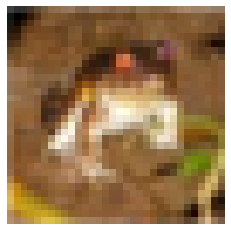

In [9]:
show(train_ds[0][0])

It's a frog! Well, maybe. 32x32 images can be very ambiguous, also for humans. Let's visualize a few more images by using another pytorch utility function ` make_grid`



['frog', 'truck', 'truck', 'deer', 'car', 'car', 'bird', 'horse', 'ship', 'cat', 'deer', 'horse', 'horse', 'bird', 'truck', 'truck', 'truck', 'cat', 'bird', 'frog', 'deer', 'cat', 'frog', 'frog', 'bird', 'frog', 'cat', 'dog', 'deer', 'plane', 'plane', 'truck']


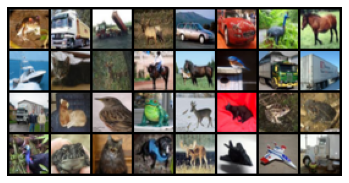

In [10]:
images = []
labels = []
for i in range(32):
  images.append(train_ds[i][0])
  labels.append(classes[train_ds[i][1]])
print(labels)
show(torchvision.utils.make_grid(images))

CIFAR-10 does not define a **validation set**, so we have to create it. We randomly sample 5000 samples out of the 50000 images of the training set.

In [11]:
splitted_datasets = torch.utils.data.random_split(train_ds, [45000, 5000])
actual_train_subds = splitted_datasets[0]
valid_subds = splitted_datasets[1]

`Dataset`s are a useful utility, and we will use them in the upcoming lessons to create `DataLoader`s, and even more powerful and important concept.

But in this exercise to keep things as simple as possible and focus on the k-NN classifier, I'll build a matrix of flattened images (=features) out of the `Dataset`s. 

Another important thing we are going to do while creating the matrices is to reduce the number of samples we will use in the next cells to develop and debug/test the classifier. This is usually a good practice and it will save you **a lot** of time. Don't worry, if it is not clear how we do all of this: you do not need to understand this code right now.

In [12]:
def dataset_to_matrix(dset, limit=None):
  x = torch.tensor(dset.data, dtype=torch.float32).permute(0, 3, 1, 2).div_(255)
  x = x.reshape((x.shape[0], -1))
  y = torch.tensor(dset.targets, dtype=torch.int64)
  if limit is not None:
    if limit <= 0 or limit > x.shape[0]:
      raise ValueError(f'Invalid value limit={limit}; must be in the range [0, {x.shape[0]}]')
    x = x[:limit].clone()
    y = y[:limit].clone()
  return x, y

def subset_to_matrix(dset, limit=None):
  x = torch.tensor(dset.dataset.data[dset.indices,], dtype=torch.float32).permute(0, 3, 1, 2).div_(255)
  x = x.reshape((x.shape[0], -1))
  y = torch.tensor(np.array(dset.dataset.targets)[dset.indices], dtype=torch.int64)
  if limit is not None:
    if limit <= 0 or limit > x.shape[0]:
      raise ValueError(f'Invalid value limit={limit}; must be in the range [0, {x.shape[0]}]')
    x = x[:limit].clone()
    y = y[:limit].clone()
  return x, y
  
train_features, train_labels = subset_to_matrix(actual_train_subds, 500)
valid_features, valid_labels = subset_to_matrix(valid_subds, 100)
test_features, test_labels = dataset_to_matrix(test_ds, 100)
train_features.shape

torch.Size([500, 3072])

Next we define a `class` to implement a k-NN classifier. It stores the train features and labels upon creation in the `__init__` method ("training" phase), and then computes the distance between (either the $L_2$ or the $L_1$ norm of the difference, according to the value of the parameter `p`).

In [13]:
class KnnClassifier:
  def __init__(self, x_train, y_train):
    """
    Creates a new K-Nearest Neighbor classifier with the specified training data.
    
    Inputs:
    - x_train: Torch tensor of shape (n_train, D) storing training data
    - y_train: int64 torch tensor of shape (n_train,) storing training labels
    """
    self.x_train = x_train
    self.y_train = y_train
    
  def predict(self, x_test, k=1, p=2):
    """
    Make predictions using the classifier.

    Inputs:
    - x_test: Torch tensor of shape (n_test, D) storing test samples
    - k: The number of neighbors to use for predictions
    - p: The norm to use as distance

    Returns:
    - pred: Torch tensor of shape (n_test,) storing predicted labels
      for the test samples.
    - knn_indices: a list of length n_test, storing the indices of the kNN for each test sample, for visualization purposes
    """
    
    n_train = self.x_train.shape[0]
    n_test = x_test.shape[0]
    pred = torch.zeros(n_test, dtype=torch.int64)
    # We also save a list of the k-NN indices for each test sample, to visualize them later
    knn_indices = torch.zeros((n_test, k), dtype=torch.int64)

    # this version based on broadcast requires too much memory for the full dataset
    #dists = torch.norm((self.x_train.reshape((n_train, 1, -1)) - x_test.reshape(1, n_test, -1)), p=p, dim=2)
    #_, knn_indices = torch.topk(dists, k, dim=1, largest=False)
    for test_index in range(n_test):
      test_vector = x_test[test_index,:]
      dists = torch.norm((self.x_train - test_vector), p=p, dim=1)
      _, indices = torch.topk(dists, k, largest=False)
      pred[test_index] = torch.bincount(self.y_train[indices]).argmax()
      knn_indices[test_index,:] = indices
    return pred, knn_indices

We can then create one on the reduced datasets we are using for development and rapid testing, and, as a sanity check, predict the labels **again for the training set** for a specific values of its hyper-parameters, i.e. `k=1` and `p=2`.

In [14]:
small_knn = KnnClassifier(train_features, train_labels)
predictions, _ = small_knn.predict(train_features, k=1)
predictions.shape

torch.Size([500])

We then define a function to compute the accuracy of our classifier and measure it. Which value do you expect?

In [15]:
def accuracy(predictions, labels):
    """
    Utility method to compute the accuracy of a classifier on test data.
    
    Inputs:
    - pred: Torch tensor of shape (n_test,) storing classifier predictions
    - labels: Torch tensor of shape (n_test,) storing labels

    Returns:
    - accuracy: Accuracy of this classifier on the test data
    """
    n_samples = labels.shape[0]
    n_correct = (labels == predictions).sum().item()
    accuracy = n_correct / n_samples
    
    return n_correct, accuracy

n_correct, acc = accuracy(predictions, train_labels)
print(f'Got {n_correct} / {train_labels.shape[0]} correct classifications; accuracy is {acc:.3f}')
    

Got 500 / 500 correct classifications; accuracy is 1.000


That's correct. A k-nn classifier **with k=1 and tested on the training set** should always achieve perfect accuracy. This is a clear example of overfitting, as we discussed. This partially validates the correctness of our implementation.

Let's know find a more sensible values for the hyper-parameters, i.e. let's implement **model selection**.

In [16]:
def model_selection(knn, valid_features, valid_labels):
  start = timer()
  best_acc = 0
  for k in [1,3,5,7,10,15,30]:
    for p in [1,2]:
      predictions, _ = knn.predict(valid_features, k=k, p=p)
      n_correct, acc = accuracy(predictions, valid_labels)
      print(f"acc {acc:.3f}, k={k}, p={p}")
      if acc > best_acc:
        print(f" - Found new best accuracy")
        best_acc = acc
        best_pred = predictions
        best_k = k
        best_p = p
  end = timer()
  print(f"Elapsed time (s): {end-start:.3f}")
  return best_k,best_p



To validated it, let's first run it again on the training set. We expect to obtain the best accuracy for `k=1` and the first metric we try (`p=1` in our implementation), and to see the accuracy decreasing as we grow `k`.

In [17]:
model_selection(small_knn, train_features, train_labels)

acc 1.000, k=1, p=1
 - Found new best accuracy
acc 1.000, k=1, p=2
acc 0.590, k=3, p=1
acc 0.566, k=3, p=2
acc 0.452, k=5, p=1
acc 0.446, k=5, p=2
acc 0.416, k=7, p=1
acc 0.396, k=7, p=2
acc 0.368, k=10, p=1
acc 0.338, k=10, p=2
acc 0.338, k=15, p=1
acc 0.320, k=15, p=2
acc 0.294, k=30, p=1
acc 0.278, k=30, p=2
Elapsed time (s): 30.384643595


(1, 1)

Good. Know let's run it for real, on the validation set. Here we do not know what to expect as a result (otherwise we wouldn't run model selection!) but we should see values for the accuracy which do not vary too wildly, with a peak and a slowly declining tail of values, if our implementation is correct.

In [18]:
model_selection(small_knn, valid_features, valid_labels)

acc 0.300, k=1, p=1
 - Found new best accuracy
acc 0.330, k=1, p=2
 - Found new best accuracy
acc 0.310, k=3, p=1
acc 0.320, k=3, p=2
acc 0.270, k=5, p=1
acc 0.290, k=5, p=2
acc 0.300, k=7, p=1
acc 0.250, k=7, p=2
acc 0.300, k=10, p=1
acc 0.260, k=10, p=2
acc 0.270, k=15, p=1
acc 0.300, k=15, p=2
acc 0.240, k=30, p=1
acc 0.260, k=30, p=2
Elapsed time (s): 6.156292699000005


(1, 2)

Happy with the results, we can now run it on the full dataset. This will take a while (about 5 hours), be patient (and read a paper in the meanwhile).

In [19]:
train_features, train_labels = subset_to_matrix(actual_train_subds)
valid_features, valid_labels = subset_to_matrix(valid_subds)
test_features, test_labels = dataset_to_matrix(test_ds)

In [23]:
# commenting this out to show results in class
#valid_knn = KnnClassifier(train_features, train_labels)
#best_k, best_p = model_selection(valid_knn, valid_features, valid_labels)
best_k, best_p = 7,1
best_k, best_p

(7, 1)

Having selected the best model, we can finally run it on the test set. As training set, we can now use the full training set, putting back into it the held-out dataset we used for validation.

In [ ]:
train_valid_features = torch.cat((train_features, valid_features))
train_valid_labels = torch.cat((train_labels, valid_labels))
start = timer()
final_knn = KnnClassifier(train_valid_features, train_valid_labels)
predictions, knn_indices = final_knn.predict(test_features, best_k, best_p)
end = timer()
n_correct, acc = accuracy(predictions, test_labels)
print(f'Got {n_correct} / {test_labels.shape[0]} correct classifications; accuracy is {acc:.3f} (elapsed time (s): {end-start:.3f})')

and visualize some of its predictions together with the nearest neighbors used to compute it.

In [ ]:
def show_predictions(train_valid_features, train_valid_labels, test_features, test_labels, knn_indices, predictions):
  n_classes = 10
  for i in range(n_classes):
    sample_indices = torch.nonzero(test_labels == i)
    plt.subplot(knn_indices.shape[1]+1, n_classes, i+1)
    show(test_features[sample_indices[0], :].reshape(3,32,32))
    plt.title(classes[i] + "\n" + classes[predictions[sample_indices[0]]])
    for j in range(knn_indices.shape[1]):
      plt.subplot(knn_indices.shape[1]+1, n_classes, (j+1)*n_classes + (i+1))
      train_index = knn_indices[sample_indices[0],j]
      plt.title(classes[train_valid_labels[train_index].item()])
      show(train_valid_features[train_index].reshape(3,32,32))
    plt.subplots_adjust(hspace = 0.6) 
show_predictions(train_valid_features, train_valid_labels, test_features, test_labels, knn_indices, predictions)


# That's all, folks